# Exploratory Data Analysis
### `! git clone https://github.com/ds4e/EDA`

## Exploratory Data Analysis
- Once the data are cleaned up, we'll want to do some basic statistical summaries and visualizations to understand their fundamental properties and whether they are clean enough to proceed, and this is called **Exploratory Data Analysis**
- Since we are doing EDA and not Visualization, we'll focus on cranking graphs out and their rough interpretation, not thinking too seriously about them as analytics
- We'll introduce the Seaborn package alongside the Pandas plots
- Last time, we cleaned the pretrial data, which works well for visualizations: There are many interesting numeric variables, categorical variables, and dummy variables. We'll use it again today.
- You probably know most or all of the ideas introduced, but perhaps not in Pandas and Seaborn

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt # Pandas automatically uses some pyplot functions, so we need it loaded

df = pd.read_csv('./data/pretrial_data.csv') # Local file

## Transform some badly scaled variables:
df['bond_arcsinh'] = np.arcsinh(df['bond'])
df['sentence_arcsinh'] = np.arcsinh(df['sentence'])
df['prior_F_arcsinh'] = np.arcsinh(df['prior_F'])
df['prior_M_arcsinh'] = np.arcsinh(df['prior_M'])

print(df.head(),'\n')
print(df.describe(),'\n')

   Unnamed: 0 case_type   age sex race  is_poor  bond  bond_type  prior_F  \
0           0         F  31.0   M    W      NaN   NaN          7      0.0   
1           1         F  60.0   M    B      NaN   NaN          7     13.0   
2           2         M  27.0   M    W      NaN   NaN          7      0.0   
3           3         M  27.0   M    B      0.0   NaN          7      0.0   
4           4         F  28.0   F    W      0.0   NaN          7      0.0   

   prior_M  ...  released  sentence_type   sentence  bond_NA  held_wo_bail  \
0      0.0  ...       NaN            NaN        NaN     True         False   
1     21.0  ...       0.0            0.0  60.000000     True         False   
2      0.0  ...       0.0            1.0  12.000000     True         False   
3      9.0  ...       0.0            1.0   0.985626     True         False   
4      0.0  ...       1.0            4.0   0.000000     True         False   

   sentence_NA  bond_arcsinh  sentence_arcsinh  prior_F_arcsinh  \
0

## Histograms: Visualizing Frequency
- A *histogram* is a fundamental and powerful tool for visualizing numeric data:
  - Take the minimum and maximum values the variable takes, and divide the range into $B$ equally spaced *bins*. For example, if the min is 0 and the max is 100 and $B=4$, the bins are $\{ [0,25), [25,50), [50,75), [75,100] \}$.
  - For each bin, you count the number of observations that fall into that bin
  - Plot the result as a bar graph, where the count in the bin equals the height of the bar
- At this stage, picking the number of `bins=B` is a matter of "taste"
- Let's histogram the Gini coefficient to see an example

<Axes: >

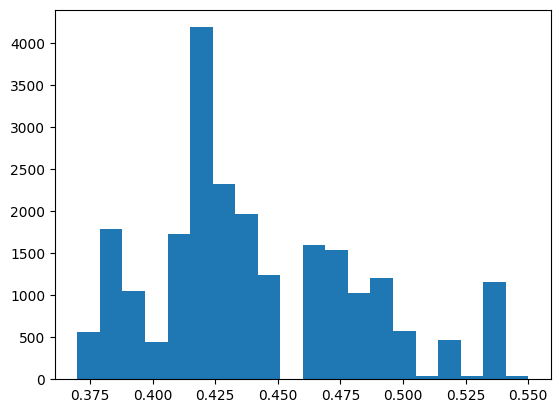

In [20]:
df['gini'].hist(bins=20,grid=False) # Here is an OK-looking histogram

- Great, that helps show us how Gini is distributed
- What about bond? That's one of our key variables that we really care about

<Axes: >

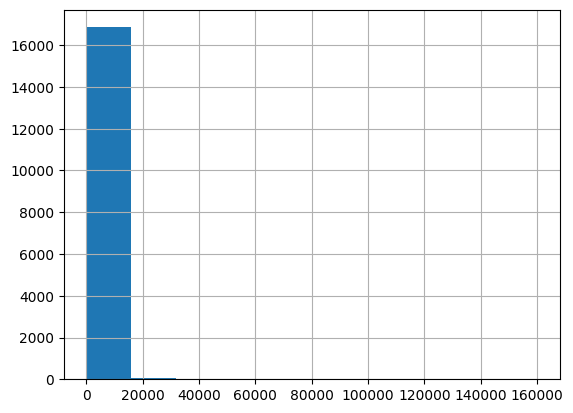

In [21]:
df['bond'].hist() # This is not a very useful histogram...

## Variables with "Long Tails"
- That looks bad; not useful and misleading at best
- We often get graphs that are not meaningful to us because their values are **badly scaled**
- Computers, likewise, dislike variables with bad scaling: stable calculations become challenging when comparing numbers of very different magnitudes
- The traditional way to smooth them is to use the **(natural) logarithm** or `log()` function: This converts multiplication/division to addition/subtraction, or levels to growth rates, and shrinks large values significantly
- `log()` is only defined as a real number for for strictly positive numbers, so it forces us to drop zeros and negative numbers from visualizations or analysis: This is highly undesirable
- The **inverse hyperbolic sine** function, `arcsinh()`, is defined for any number, positive or negative, and has almost the same interpretation, so we often use it instead

/home/mgh2xx/.local/lib/python3.10/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: >

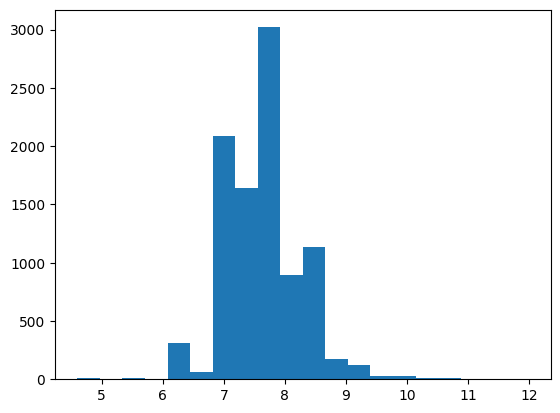

In [22]:
df['bond_log'] = np.log(df['bond'])
# df['bond_log'].hist() # This crashes: We need to locate the non-infinte values
df.loc[df['bond_log']>0,'bond_log'].hist(bins=20,grid=False)

<Axes: >

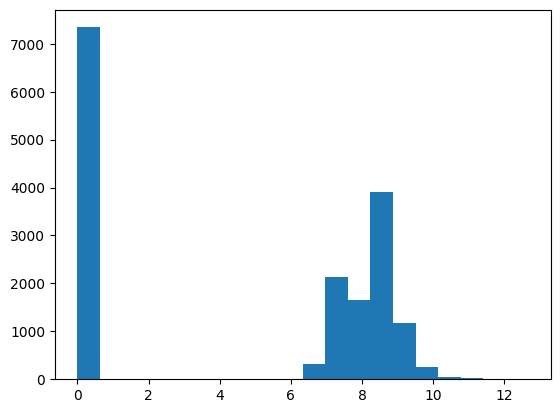

In [23]:
df['bond_arcsinh'] = np.arcsinh(df['bond'])
df['bond_arcsinh'].hist(bins=20,grid=False) # Notice all the data at zero that log throws away

## `log()` versus `arcsinh()` [Math]
- The derivative of natural log is $1/x$, while for inverse hyperbolic sine it is $1/\sqrt{1+x^2}$, which are so close as to render the difference negligible for our purposes
- We won't go over it now, but it's typically easy to go back and forth between the transformed analysis and the original values in levels, so using the transformations are not a problem in analysis
- Since `arcsinh(0)=0` but `log` tends to negative infinity at zero and their derivatives are similar, the `arcsinh` curve lies above the `log` curve

/tmp/ipykernel_2234/2551805020.py:3: RuntimeWarning: invalid value encountered in log
  y1 = np.log(x)


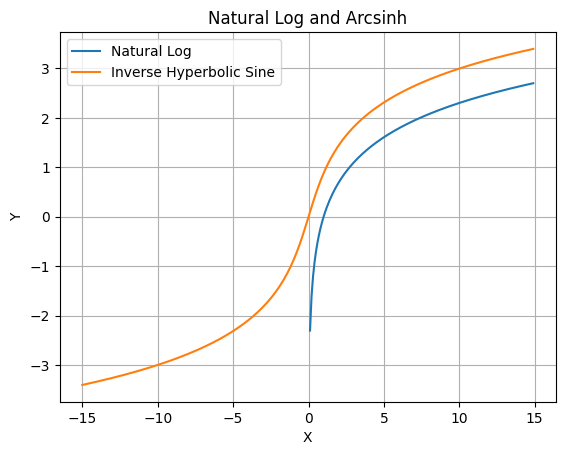

In [24]:
# Quick matplotlib plot of log and arcsinh:
x = np.arange(-15,15,.1)
y1 = np.log(x)
y2 = np.arcsinh(x)
plt.plot(x,y1, label ='Natural Log')
plt.plot(x,y2, label='Inverse Hyperbolic Sine')
plt.xlabel("X")
plt.ylabel("Y")
plt.grid()
plt.legend(loc='upper left')
plt.title('Natural Log and Arcsinh')
plt.show()

## Statistics
- Our subsequent plots will involve a bit more statistical computation, so we'll pause and talk about some statistics concepts
- A **(sample) statistic** is a function of the data: We take a list of values, and aggregate it into a summary number(s) that helps us better understand the phenomenon we're interested in
- An example is the **mean** or **average**: We sum all of the values, and divide by the total number of values. If we have $N$ observations and the values are $(x_1, x_2, ..., x_N)$, the average is
$$
\bar{x} = \dfrac{x_1+x_2+...+x_N}{N} = \dfrac{ \sum_{i=1}^N x_i }{N}
$$
The intuition is, "Imagine you drew a number out of the hat. They're all drawn with equal probability. What kind of number do you expect to get?"
- The field of statistics, roughly, studies the behavior of sample statistics as the sample size $N$ gets large: What is the behavior of a sample statistic as we get lots of data? Does it approach the "true" value, if one exists?
- In EDA, we're typically using statistics as a way to summarize the data and understand its features, and not necessarily imputing a "deeper meaning" to them

## Always, always, always, look at your data
![Lawyer Salaries](./src/lawyerSalaries2018.jpg)
- How *useful* is it to say, "The average yearly salary of a lawyer is about $100k?"
- Statistics can be incredibly misleading

## Statistics: Measures of Central Tendency
- These statistics correspond to values around which the data are concentrated:
    - Mode: The most frequently occuring value in the data
    - Median: The value(s) at which half the population is above and half the population is below
    - Mean: The numeric average value of the data,
$$
\bar{x} = \dfrac{x_1+x_2+...+x_N}{N} = \dfrac{ \sum_{i=1}^N x_i }{N}
$$

Mean:  0.4406351210168901
Median:  0.43
Mode:  0    0.42
Name: gini, dtype: float64


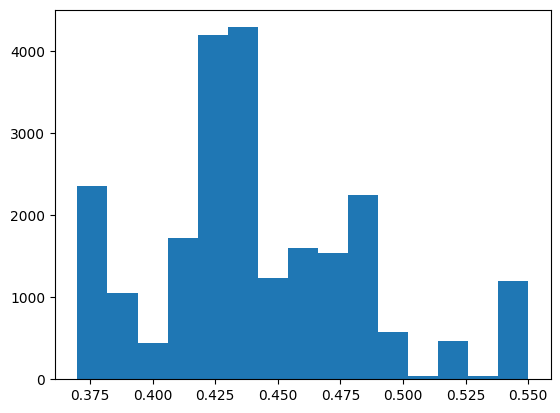

In [25]:
var = 'gini'

df[var].hist(bins=15,grid=False)
print('Mean: ', df[var].mean() )
print('Median: ', df[var].median() )
print('Mode: ', df[var].mode() )

Mean:  4.686972979300787
Median:  7.600902709541988
Mode:  0    0.0
Name: bond_arcsinh, dtype: float64


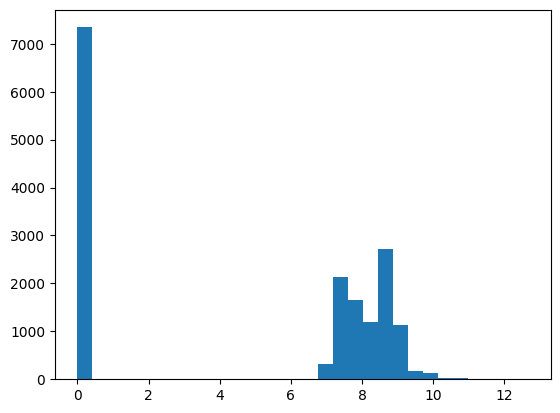

In [26]:
df['bond_arcsinh'] = np.arcsinh(df['bond'])

var = 'bond_arcsinh'

df[var].hist(bins=30,grid=False)
print('Mean: ', df[var].mean() ) # Does anyone actually get 4.68697?
print('Median: ', df[var].median() )
print('Mode: ', df[var].mode() )

## Statistics: Measures of Rank
- Imagine lining the data up by magnitude, from smallest to largest
- The **p-th percentile** is the value for which $p\%$ of the population is below $p$'s value and $(1-p)\%$ of the population is above $p$'s value
- If you use decimals instead of percents, like $.05$ for $5\%$ or $.50$ for $50\%$, the word **quantile** is typically used
- This ranks observations from smallest to largest by the proportion of the sample it "defeats"
- Why? Quantiles and the median are robust to outliers: Moving extremely large or small values won't affect the median or significantly change the rankings.
- The **Empirical Cumulative Distribution Function (ECDF)** essentially plots all the quantiles

Minimum:  0.37
0th quantile:  0.37
.05 quantile:  0.38
.10 quantile:  0.38
.25 quantile:  0.42
.50 quantile:  0.43
.75 quantile:  0.47
.90 quantile:  0.5
.95 quantile:  0.54
1.00 quantile:  0.55
Sample Maximum: 0.55


<Axes: xlabel='gini'>

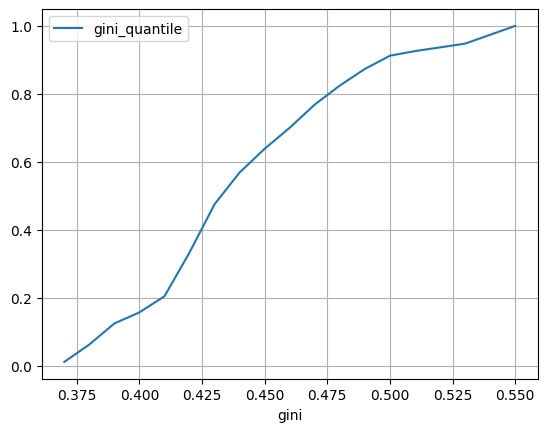

In [27]:
# Sample quantiles for the gini variable:
var = 'gini'
print('Minimum: ', df[var].min())
print('0th quantile: ', df[var].quantile(0))
print('.05 quantile: ', df[var].quantile(.05))
print('.10 quantile: ', df[var].quantile(.10))
print('.25 quantile: ', df[var].quantile(.25))
print('.50 quantile: ',df[var].quantile(.50))
print('.75 quantile: ',df[var].quantile(.75))
print('.90 quantile: ',df[var].quantile(.90))
print('.95 quantile: ',df[var].quantile(.95))
print('1.00 quantile: ',df[var].quantile(1))
print('Sample Maximum:', df[var].max())

# A quick Empirical Distribution Function plot:
df['gini_quantile'] = df['gini'].rank(method = 'average', pct = True) # Ranks the values
df.sort_values('gini').plot(x = 'gini', y = 'gini_quantile', grid = True)


Minimum:  0.0
0th quantile:  0.0
.05 quantile:  0.0
.10 quantile:  0.0
.25 quantile:  0.0
.50 quantile:  1000.0
.75 quantile:  2500.0
.90 quantile:  3500.0
.95 quantile:  5000.0
1.00 quantile:  160000.0
Sample Maximum: 160000.0


<Axes: xlabel='bond'>

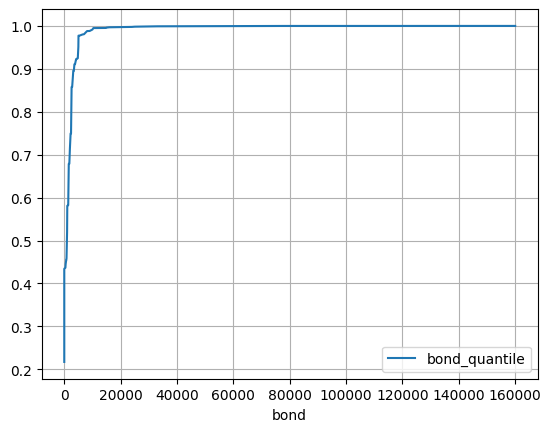

In [28]:
# Sample quantiles for the bond variable:
var = 'bond'
print('Minimum: ', df[var].min())
print('0th quantile: ', df[var].quantile(0))
print('.05 quantile: ', df[var].quantile(.05))
print('.10 quantile: ', df[var].quantile(.10))
print('.25 quantile: ', df[var].quantile(.25))
print('.50 quantile: ',df[var].quantile(.50))
print('.75 quantile: ',df[var].quantile(.75))
print('.90 quantile: ',df[var].quantile(.90))
print('.95 quantile: ',df[var].quantile(.95))
print('1.00 quantile: ',df[var].quantile(1))
print('Sample Maximum:', df[var].max())

# A quick Empirical Distribution Function plot:
df['bond_quantile'] = df['bond'].rank(method = 'average', pct = True) # Ranks the values
df.sort_values('bond').plot(x = 'bond', y = 'bond_quantile', grid = True)

## Statistics: Measures of Dispersion
- In addition to the raw quantiles, we have a variety of statistics we can use to capture similar information about how "spread out" the data are:
    - Range: The minimum and maximum values of the data
    - Interquartile Range: The distance between the 25%-quantile and 75%-quantile, which includes the middle half of the data
    - Variance: The average squared distance from the mean,
$$
s^2 = \dfrac{(x_1-\bar{x})^2 + (x_2 + \bar{x})^2 + ... + (x_N - \bar{x})^2}{N-1} = \dfrac{\sum_{i=1}^N (x_i-\bar{x})^2 }{N-1}
$$
So take the value of each observation $i$, subtract off the mean $\bar{x}$, square that, and then divide by $N-1$. If the data are all clustered around $\bar{x}$, this will be small, but if the data are very spread out, this will be larger.
    - Standard Deviation: The square root of the variance,
$$
s = \sqrt{s^2} = \sqrt{ \dfrac{\sum_{i=1}^N (x_i-\bar{x})^2 }{N-1} }
$$
- ...why? The standard deviation is in the same units as the original variable, but the variance is approximately an average. They end up having have different statistical properties in small samples. Some models are more naturally parameterized in terms of the variance rather than the standard deviation.

## Boxplots
- The rank and dispersion information is useful to illustrate in a plot, since it can feel somewhat abstract compared to a histogram
- A **boxplot** is roughly a visualization of the 5-number summary:
    - The green bar is the median/50%-quantile
    - The **box** represents the interquartile range (IQR): The range of values containing everything from the 25%-quantile to the 75%-quantile
    - The **whiskers** include a range of values from the first quartile minus $\frac{3}{2}IQR$ to the third quartile plus $\frac{3}{2}IQR$
    - Values outside the whiskers are typically considered **outliers**
- This plot is intended to illustrate the rank information in a useful way

<Axes: >

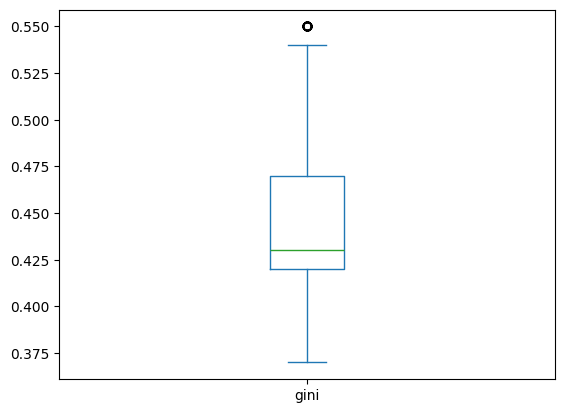

In [29]:
#df.boxplot(column = 'gini')
df['gini'].plot.box()

<Axes: >

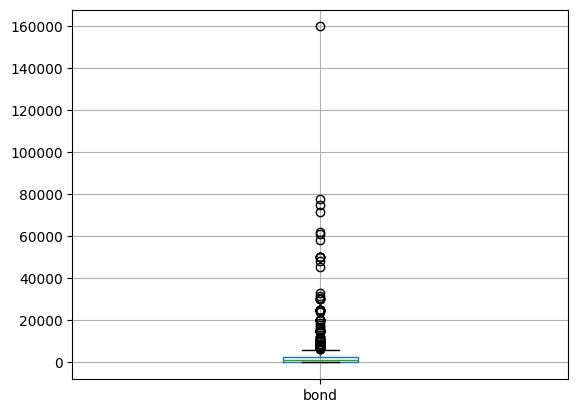

In [30]:
df.boxplot(column = 'bond')

<Axes: >

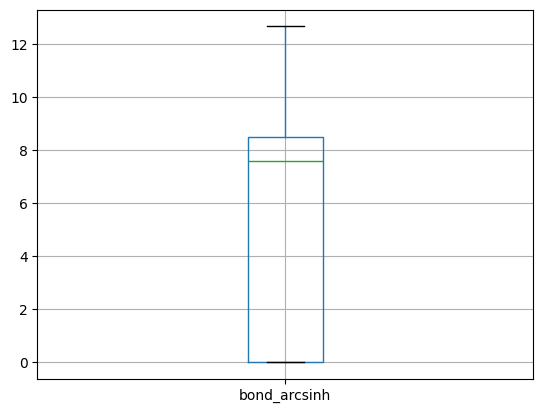

In [31]:
df.boxplot(column = 'bond_arcsinh')

## What do you do with outliers?
- Maybe nothing: They're part of the data. Maybe you trim the outliers and drop them, or **windsorize** and replace them with a high or low value.
- The outliers will typically exert *leverage* on the analysis: extreme values will influence the outcomes of your estimates or algorithm (e.g. they disproportionately affect the variance)
- But if the outliers are "really part of the data," that leverage can be totally legitimate: Wildfires, market crashes, earthquakes/tsunamis, data breaches. Sometimes extreme events are the point.
- What you want to be certain of is that the outliers are actually representative of the population of interest --- some observations might have characteristics that make them uncharacteristic of the data you expect to see in the future, and your models will be less useful if they are trained on those data
- The field of *robust statistics* is generally concerned with estimating models when the presence of outliers is likely to interfere with the results

## A Compromise: Winsorizing
- In some cases, we think some observations are fairly extreme and we don't want them to have leverage on our estimates or predictions, but we're also loathe to throw away data
- In this case, we often **winsorize**: For the outliers ( or outside some quantile threshold like .01/.99 or .025/.975) we replace the extremely large and small values with the values of the whiskers. If you do this, you should also make a "winsorized dummy" to note that you edited the data this way. 
- How to do this with economical code?

count    22986.000000
mean         0.014705
std          0.120370
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: bond, dtype: float64


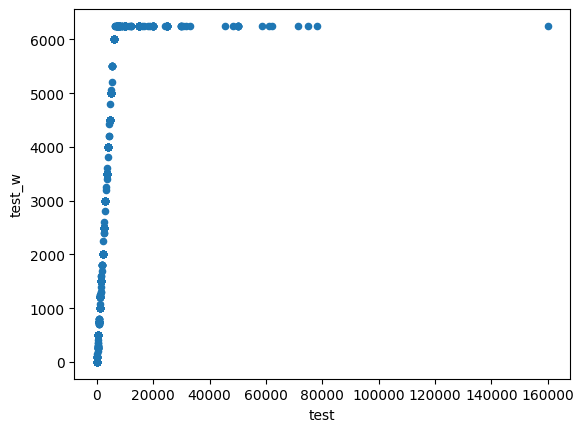

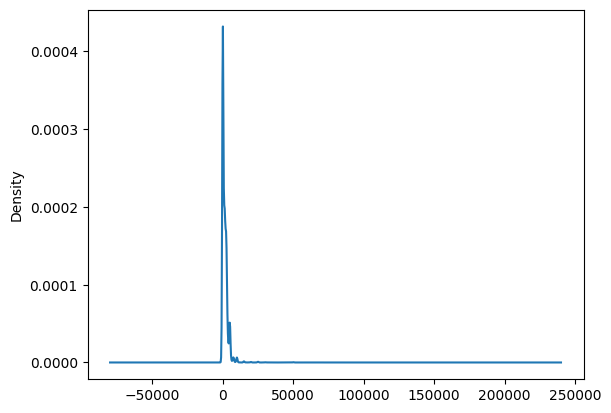

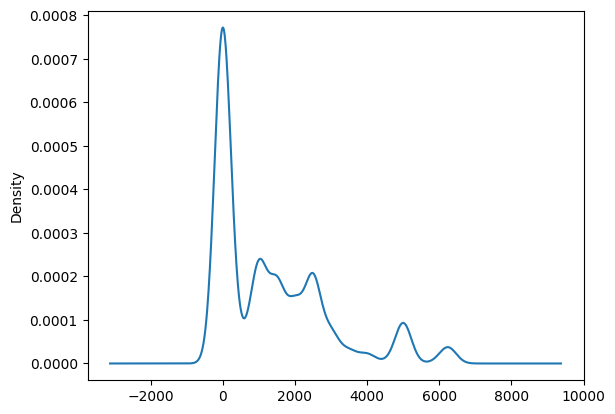

In [32]:
def winsorize(var):
    """ Winsorize a Pandas series, also returning a winsorized dummy. """
    lower = var.quantile(.25)
    upper = var.quantile(.75)
    IQR = upper-lower
    upper_whisker = upper + 3/2 * IQR
    lower_whisker = lower - 3/2 * IQR
    is_outlier =  ( (var > upper_whisker) + (var < lower_whisker) ).astype(int)
    var_w = (var > upper_whisker) * upper_whisker + (var < lower_whisker) * lower_whisker + (1-is_outlier) * var
    return var_w, is_outlier
        
test = df['bond']        
test_w, test_outlier = winsorize(test)
print(test_outlier.describe())
tdf = pd.DataFrame({'test':test, 'test_w':test_w})
tdf.plot.scatter(x='test',y='test_w')
plt.show()

df['bond'].plot.density() # Density plot of raw bonds
plt.show()

tdf['test_w'].plot.density() # Density plot of windsorized bonds
plt.show()

- This is an alternative to the log/ihs transformations: Winsorize the outliers to the whisker values
- Choices have consequences: This will likely impact analytics later.

## Variable Descriptions/Summaries
- This is a bunch of ways of slicing the data, and there are many, many more
- Many stats packages report a five-number+ summary: The minimum, the 25%/median/75% percentiles, the maximum, the mean and standard deviation, and how many non-missing observations are recorded (count)
- In Pandas, you can do this with `df[var].describe()`
- From `.describe()`, you can quickly compute almost all the statistics we've mentioned
- The `count` value is the number of non-missing entries

In [33]:
descr = df['age'].describe() # Describe age and save as an object
print(descr,'\n')

# Computing the Variance:
std = descr[2] # Accessing the standard deviation from the description object
var = std**2
print('Variance: ', var,'\n')

# Computing the IQR:
thirdQ = descr[6] # Getting the 75% percentile
firstQ = descr[4] # Getting the 25% percentile
IQR = thirdQ - firstQ # Computing the IQR
print('IQR: ', IQR)

count    22930.000000
mean        34.278020
std         12.466248
min         18.000000
25%         24.000000
50%         31.000000
75%         42.000000
max        100.000000
Name: age, dtype: float64 

Variance:  155.4073279301658 

IQR:  18.0


/tmp/ipykernel_2234/3490558612.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  std = descr[2] # Accessing the standard deviation from the description object
/tmp/ipykernel_2234/3490558612.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  thirdQ = descr[6] # Getting the 75% percentile
/tmp/ipykernel_2234/3490558612.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  firstQ = descr[4] # Getting the 25% percentile


## Bivariate EDA
- Up to here, we've looked at a single variable, and ways of summarizing it with plots and statistics
- How do we generalize to two variables (or more, in some cases)?

## Scatter Plots
- Just like cross-tabs allow you to think about two variables at once, scatter plots provide a way of looking at the association between two variables in the data set
- What's a scatterplot? Pick two variables, $x$ and $y$. For each pair of values $(x_i, y_i)$ for observation $i$, you make a dot. Plot all the dots for all observations, $i=1,...,N$.
- The goal is typically to uncover patterns of association between the two variables

<Axes: xlabel='age', ylabel='gini'>

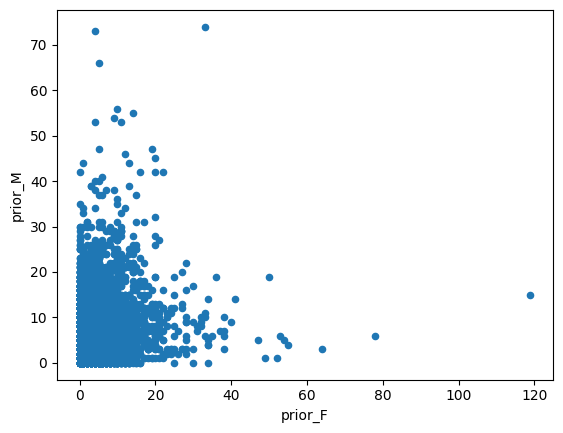

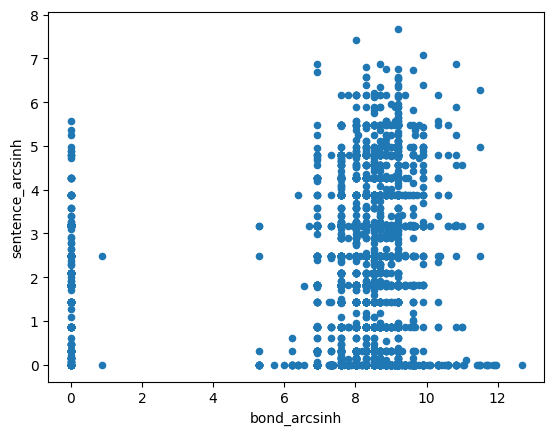

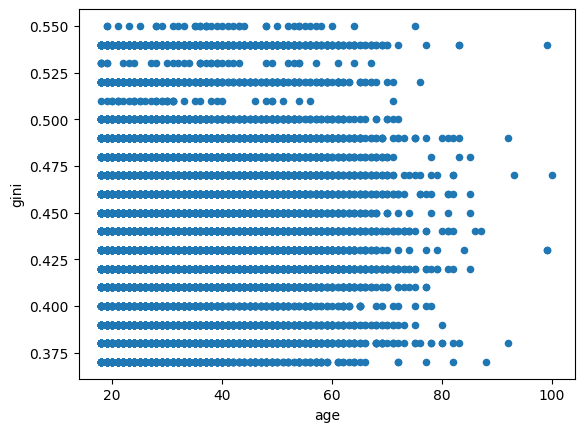

In [34]:
df.plot.scatter(y='prior_M',x='prior_F')
df.plot.scatter(x='bond_arcsinh',y='sentence_arcsinh')
df.plot.scatter(y='gini',x='age')

## Statistics: Measures of Association
- Covariance: Essentially, the common variance between two variables
\begin{alignat*}{2}
\text{cov}(x,y) &=& \dfrac{(x_1-\bar{x})(y_1-\bar{y}) + (x_2-\bar{x})(y_2-\bar{y})+...+(x_N-\bar{x})(y_N-\bar{y}) }{N-1} \\
&=& \dfrac{\sum_{i=1}^{N} (x_i-\bar{x})(y_i-\bar{y}) }{N-1}
\end{alignat*}

Notice how $\text{cov}(x,x) = s^2$.
- Look at each pair $x_i$ and $y_i$. If they tend to both be above or below their averages, then there is positive covariance. If one tends to be above its average when the other is below, then there is negative covariance.
- Correlation: The covariance normalized by the standard deviation of each variable is
$$
r_{x,y} = \dfrac{\text{cov}(x,y)}{ s_x s_y}
$$
This is helpful because it is between zero and 1, with 1 being perfect positive correlation, -1 being perfect negative correlation, and 0 being no correlation at all

## Covariance and Correlation Matrices
- The function `df.cov()` will compute all of the variances and covariances for everything in your dataframe, and `df.corr()` will compute the correlations
- The output will be a matrix: The variances of the variables will be on the diagonal, and the covariances/correlations will be the off-diagonal terms
- You probably want to use `df.loc[:,list]` to restrict attention to a set of variables in `list`, rather than compute all the possible covariances/correlations

In [35]:
vars = ['prior_M','prior_F']

VCV = df.loc[:,vars].cov() # Compute the variance-covariance matrix for vars
print(VCV,'\n')

cor = df.loc[:,vars].corr() # Compute the correlation matrix for vars
print(cor)

           prior_M    prior_F
prior_M  19.700497   6.580946
prior_F   6.580946  12.178719 

          prior_M   prior_F
prior_M  1.000000  0.424863
prior_F  0.424863  1.000000


## Limits of Linear Association
- The covariance and correlation are great tools... but they only capture linear relationships
- If there's a non-linear relationship between two variables, a casual glance at the covariance or correlation might hide it
- Let's illustrate this issue with an example: $y = 10 x^2 + e$ with $x$ values between $-1$ and $1$ and $e$ is normally distributed noise with mean 0 and standard deviation 1.

In [36]:
N = 100 # Sample size
rng = np.random.default_rng(90) # Initialize random number generator
e = rng.normal(0, 1, N) # Generate normally distributed errors

X = np.linspace(-1,1,N) # Grid of x values
Y = 10*np.pow(X,2) + e # y = x^2 + e

gdf = pd.DataFrame({'x':X,'y':Y})
gdf.plot.scatter(x='x',y='y')
gdf.corr()

AttributeError: module 'numpy' has no attribute 'pow'

,x,y
x,1.000000,0.941642
y,0.941642,1.000000


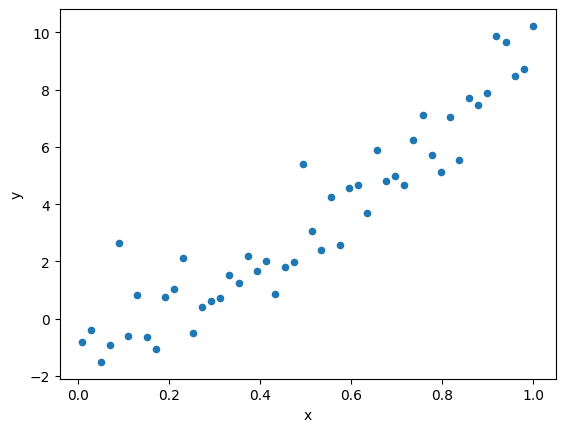

In [226]:
rdf = gdf.loc[gdf['x']>0,:] # Let's look only at the positive values
rdf.plot.scatter(x='x',y='y')
rdf.corr()

,x,y
x,1.000000,-0.931479
y,-0.931479,1.000000


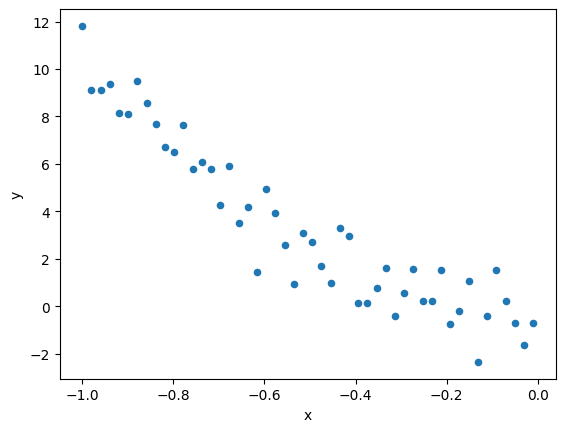

In [227]:
rdf = gdf.loc[gdf['x']<0,:] # Let's look only at the negative values
rdf.plot.scatter(x='x',y='y')
rdf.corr()

- I'm not saying covariance or correlation are bad to use; they are bad to **mindlessly** use

## Kernel Density Plots
- A downside of histograms is that plotting multiple variables on the same plot at the same time often becomes a jumbled mess: Do you stack them? Jitter them?
- The alternative is to use a smoothed line to represent each variable; this is called a **kernel density plot**
- The intuition of a kernel density plot is that each data point gets its own little bell curve, centered at its value. All the bell curves are then averaged together.
- So if data are bunched closely, their bell curves sum to a large value. If the data are sparse around some values, their sum is small
- This renders the jagged histogram into a smooth plot, which is often easier for humans to understand visually

<Axes: ylabel='Density'>

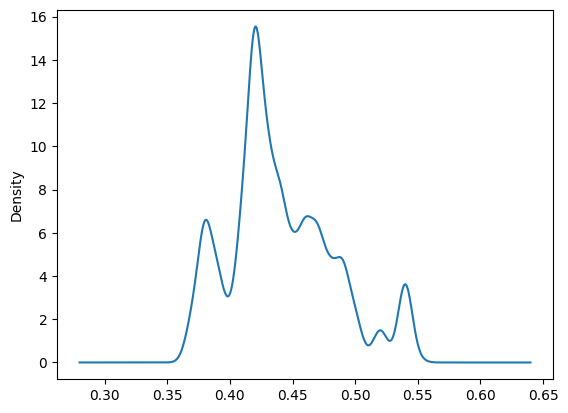

In [228]:
var = 'gini'
df[var].plot.density() # The kernel density plot for gini

<Axes: ylabel='Density'>

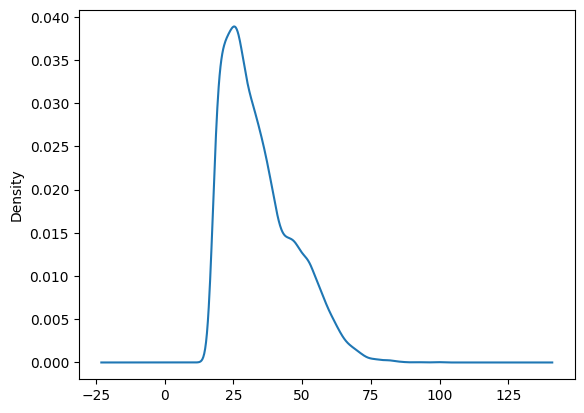

In [229]:
var = 'age'
df[var].plot.density() # The kernel density plot for age

- The upside will be that it's easy to visualize many series at once, grouped by a categorical variable, and the choice of "bins" isn't as arbitrary (there are a lot of good ways to pick the **bandwidth**)
- The downside is that if the data have big spikes, the kernel density plot struggles to represent that faithfully, because it is trying to smooth everything out:

<Axes: ylabel='Density'>

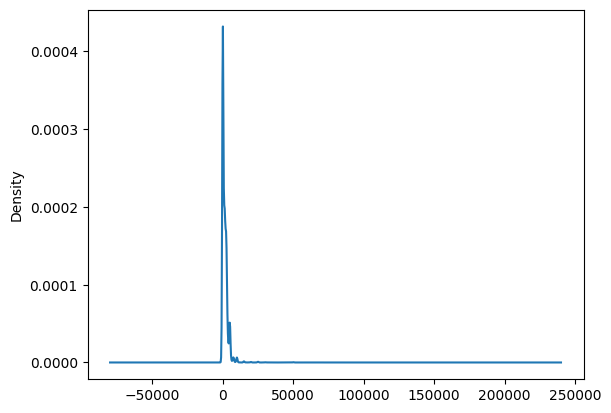

In [230]:
var = 'bond'
df[var].plot.density() # Not so good for bond

<Axes: ylabel='Density'>

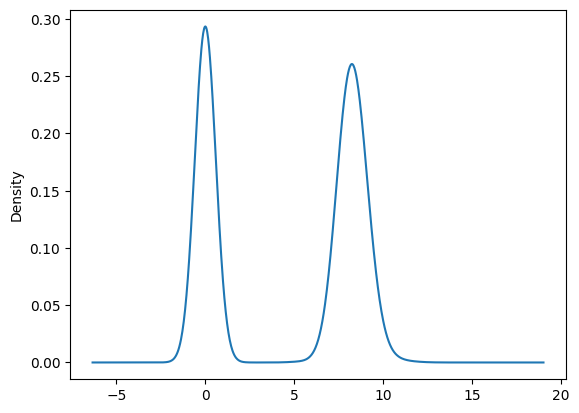

In [231]:
# the discreteness of the bond makes this plot look off:

var = 'bond_arcsinh'
df[var].plot.density() 

## Seaborn
- The Pandas plotting utilities are convenient: They're packaged with Pandas and can be called as `df['var'].thisplot()`
- They are not very extensible or aesthetically pleasing
- The Plotly and Altair packages are nice and generate interactive plots, 
- Seaborn strikes a nice balance: The plots are pretty extensible, but not interactive, but the API is still simple
- Seaborn also makes it very easy to produce plots with multiple series on the same canvas, which will be a key tool for us
- I'm going to switch to Seaborn for... the rest of the course

## Basic Plots in Seaborn
- It's nice that Pandas has built-in plotting utilities, but they're not great for building complex or attractive plots
- All the plots we made with Pandas can be done in Seaborn with almost the same syntax:
    - Histogram: `sns.histplot(df[varName])` or `sns.histplot(data=df,x=varName)`
    - Density: `sns.kdeplot(df[varName])` or `sns.kdeplot(data=df,x=varName)`
    - Boxplot: `sns.boxplot(df[varName])` or `sns.boxplot(data=df,x=varName)`
    - Scatterplot: `sns.scatterplot(df[varName1],df[varName2])` or `sns.scatterplot(data=df,x=varName1, y=varName2)`

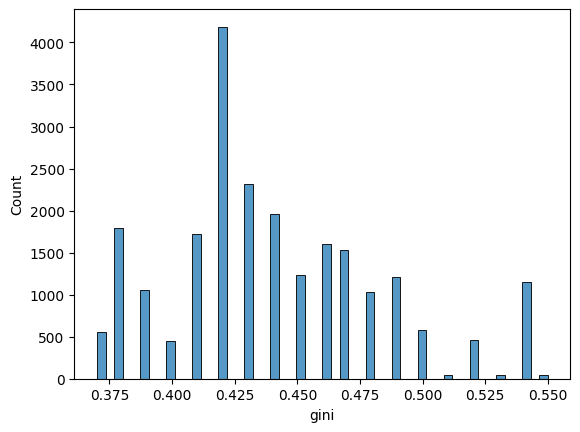

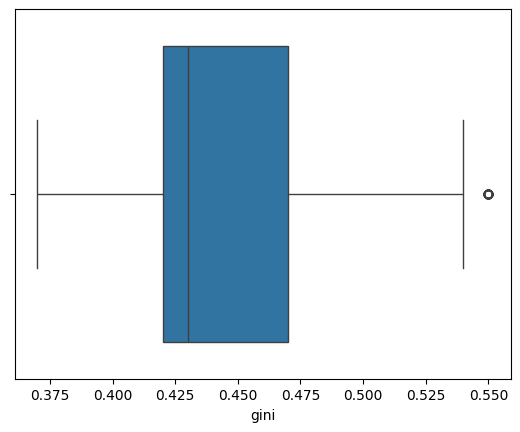

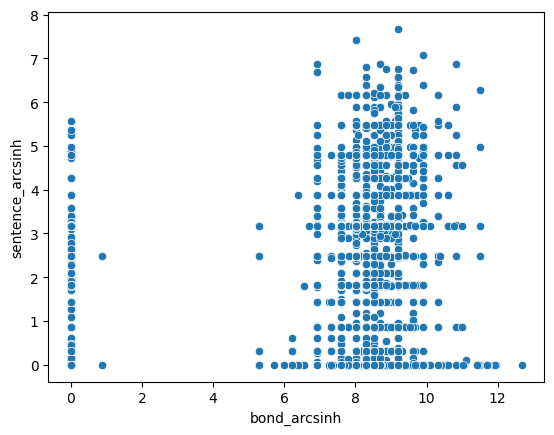

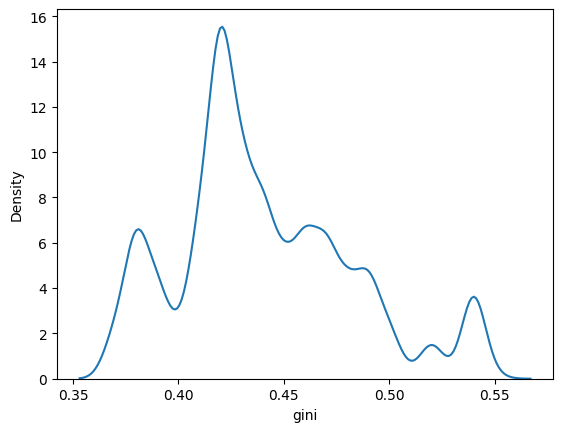

In [232]:
import seaborn as sns # Import Seaborn

# Histogram:
var = 'gini'
sns.histplot(df[var]) # A histogram
#sns.histplot(data=df, x=var) # Same thing
plt.show()

# Boxplot:
var = 'gini'
#sns.boxplot(df[var]) # A boxplot
sns.boxplot(data=df, x=var) # Same thing, but horizontal
plt.show()

# Scatterplot:
var1 = 'sentence_arcsinh'
var2 = 'bond_arcsinh'
sns.scatterplot(y=df[var1],x=df[var2]) # A scatterplot
#sns.scatterplot(data=df, y=var1, x=var2) # Same thing
plt.show()

# Kernel Density Plot:
var = 'gini'
sns.kdeplot(df[var]) # A kernel density plot
#sns.kdeplot(data=df, x=var) # Same thing
plt.show()

## Titles and Labels
- With Seaborn, there is no excuse for your plot not to have:
    1. A title
    2. Legible horizontal and vertical axis labels
    3. A legend, if there is more than one series plotted
- Your plots are ultimately to communicate. If you don't provide this basic information, you're making it much harder for people to understand what you're doing.
- We do this with `.set(title=...,xlabel=...,ylabel=...)`

[Text(0.5, 1.0, 'Gini Coefficient of Inequality'),
 Text(0.5, 0, 'Gini'),
 Text(0, 0.5, 'Density')]

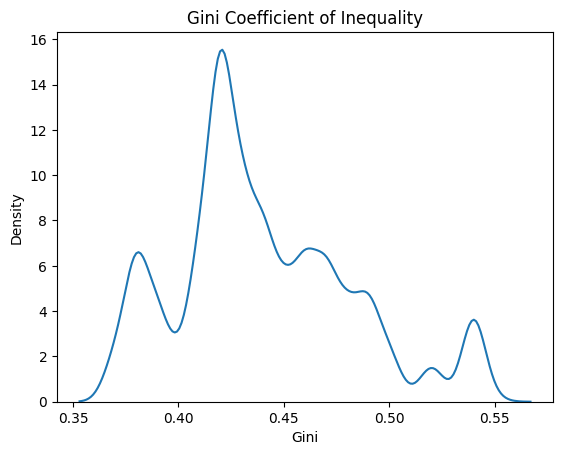

In [233]:
var = 'gini'
fig = sns.kdeplot(df[var]) 
fig.set(title='Gini Coefficient of Inequality',
xlabel='Gini', 
ylabel='Density')

## Log Transformations, Again
- Here's an alternative way to understand the log/ihs transformations
- We'll rescale the axis, instead of rescaling the variable:

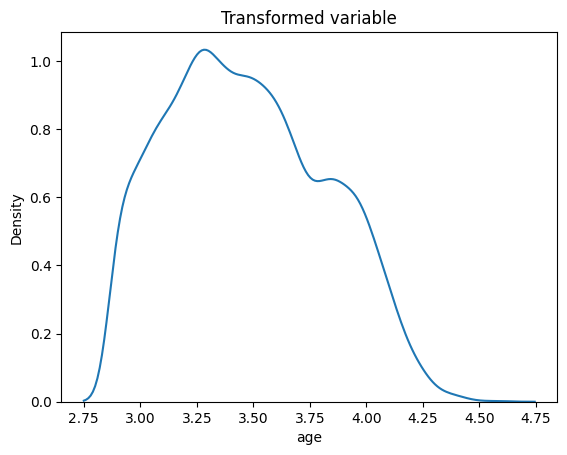

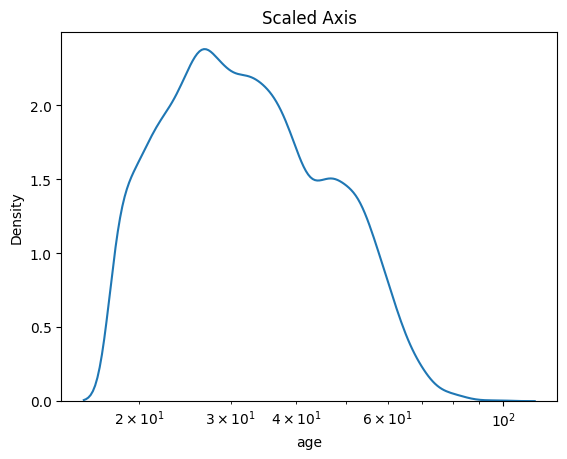

In [234]:
sns.kdeplot(x=np.log(df['age']) ).set(title='Transformed variable') 
plt.show()

sns.kdeplot(data=df,x='age',log_scale=True).set(title='Scaled Axis') 
plt.show()

## Conditioning or Grouping
- We very often want to **condition** or **group** our sample statistics and plots on specific categorical variables: For example, the bond or sentence conditional on race or sex
- This provides valuable context for what the numbers mean
- A lot of our tools immediately become more powerful when we can quantitatively differentiate between different categorical cases
- With Seaborn, you just add an extra `hue=var` argument for color or `shape=var` for shape 
- This can be difficult to do, if you use the wrong plotting technology

[Text(0.5, 1.0, 'A Bad Plot')]

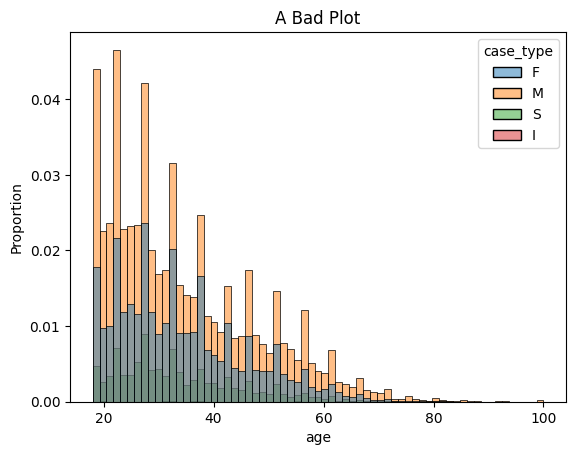

In [235]:
conditioning = 'case_type'
var = 'age' #'bond_arcsinh'
fig = sns.histplot( data=df, x=var, hue=conditioning, stat='proportion')
fig.set(title='A Bad Plot')

- Notice that grey and dark green do not appear in the legend: It's unclear who those values belong to
    - For the record, the orange are misdemeanors, the orange plus blue felonies yield the grey, and the dark green is the special cases
    - Why? A mix of Cyan, Magenta, and Yellow yield a desaturated grey. Misdemeanor-Orange is magenta and yellow, and Felony-Blue is cyan and a bit of magenta.  
- You should not need to know color theory to understand a plot

## Grouped Kernel Density Plots
- These dominate histograms decisively for illustrating multiple plots at the same time
- I highly highly recommend setting `common_norm = False` so that each density represents its population: Without doing this, the curves are normalized in proportion to their population size, which is typically not the visual comparison I want

[Text(0.5, 1.0, 'Grouped KDE Plot')]

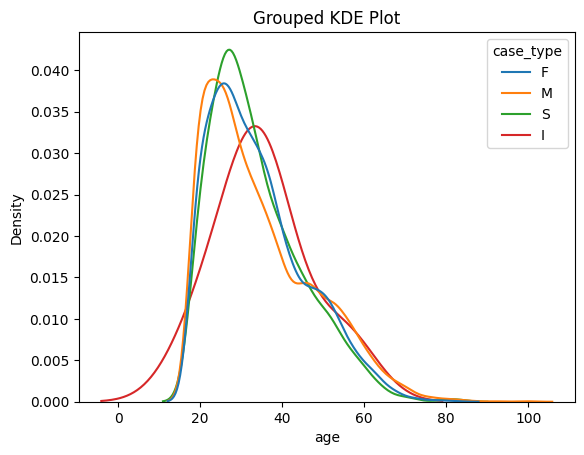

In [236]:
conditioning = 'case_type'
var = 'age' #'bond_arcsinh'
sns.kdeplot( data=df, x=var, hue=conditioning, common_norm=False).set(title='Grouped KDE Plot')

[Text(0.5, 1.0, 'Grouped KDE Plot')]

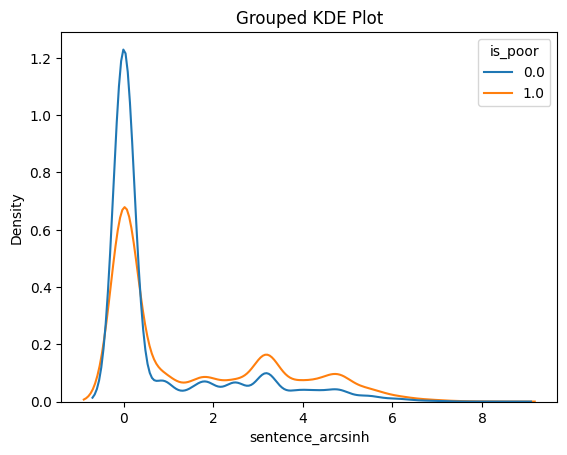

In [237]:
conditioning = 'is_poor'
var = 'sentence_arcsinh'
sns.kdeplot( data=df, x=var, hue=conditioning, common_norm=False).set(title='Grouped KDE Plot')

[Text(0.5, 1.0, 'Bond by Indigency Status')]

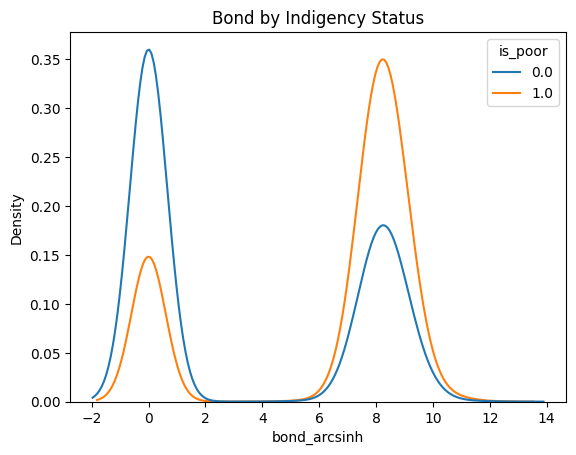

In [238]:
conditioning = 'is_poor'
var = 'bond_arcsinh'
sns.kdeplot( data=df, x=var, hue=conditioning, common_norm=False).set(title='Bond by Indigency Status')

/tmp/ipykernel_83107/2978177475.py:3: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot( data=df, x=var, hue=conditioning, common_norm=False).set(title='Sentence by Case Type')


[Text(0.5, 1.0, 'Sentence by Case Type')]

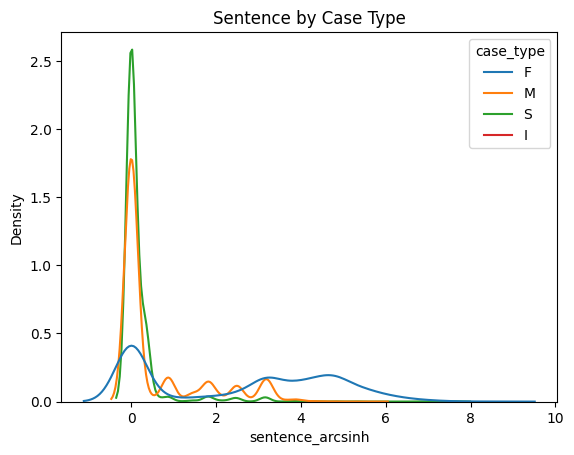

In [239]:
conditioning = 'case_type'
var = 'sentence_arcsinh'
sns.kdeplot( data=df, x=var, hue=conditioning, common_norm=False).set(title='Sentence by Case Type')

[Text(0.5, 1.0, 'Bond by Case Type')]

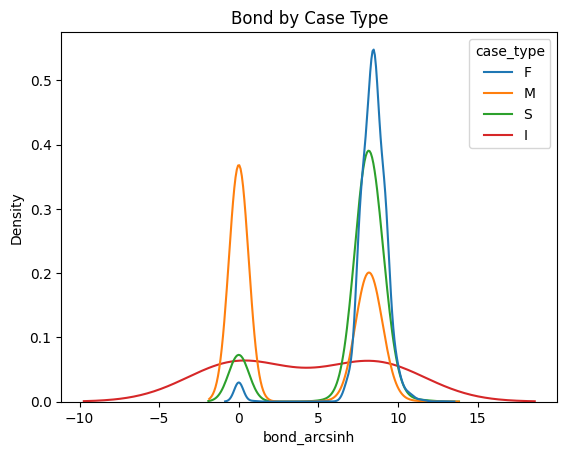

In [240]:
conditioning = 'case_type'
var = 'bond_arcsinh' #'bond_arcsinh'
sns.kdeplot( data=df, x=var, hue=conditioning, common_norm=False).set(title='Bond by Case Type')

## Grouped Boxplots
- Grouping for boxplots is even easier: `df.boxplot(column = var, by = group_by)`

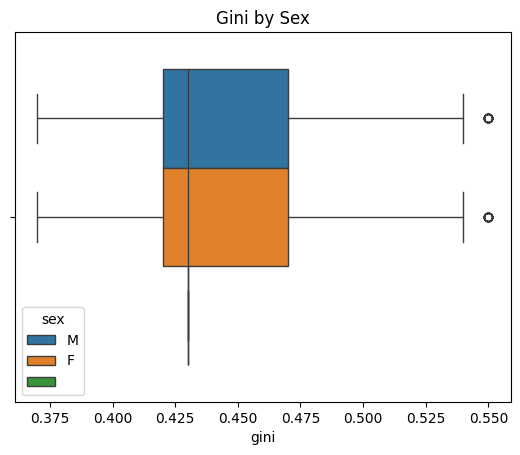

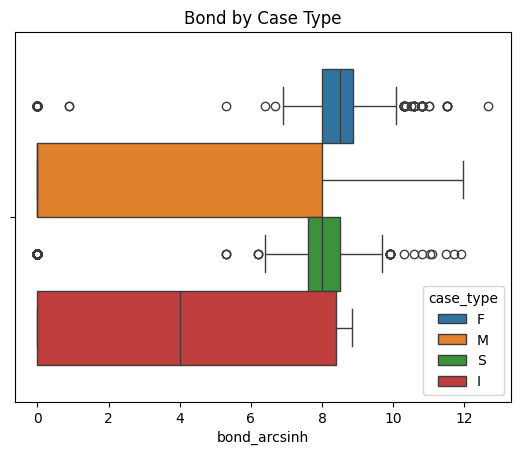

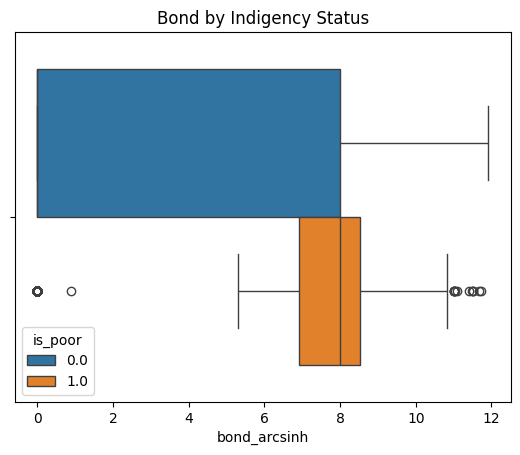

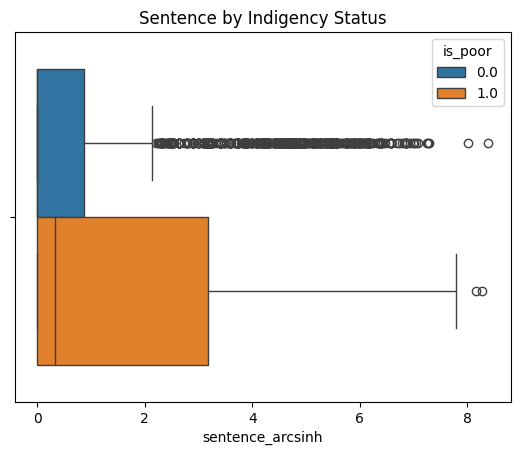

In [241]:
sns.boxplot(data=df, x = 'gini', hue = 'sex').set(title='Gini by Sex')
plt.show()

sns.boxplot(data=df, x = 'bond_arcsinh', hue = 'case_type').set(title='Bond by Case Type')
plt.show()
plt.show()

sns.boxplot(data=df, x = 'bond_arcsinh', hue = 'is_poor').set(title='Bond by Indigency Status')
plt.show()
plt.show()

sns.boxplot(data=df, x = 'sentence_arcsinh', hue = 'is_poor').set(title='Sentence by Indigency Status')
plt.show()
plt.show()

## Grouped Scatterplots
- Huing and shaping the marks can be really useful for detecting what's going on in the data:

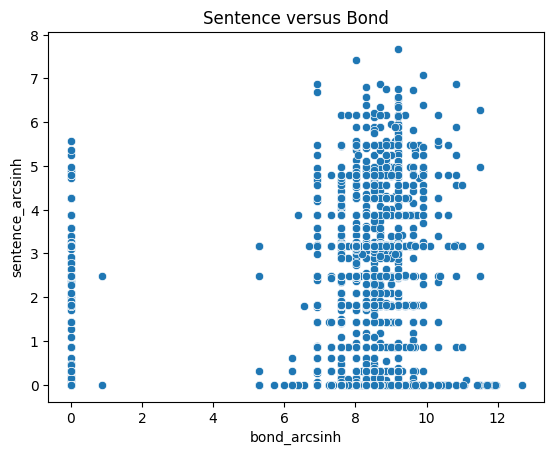

In [242]:
var1 = 'bond_arcsinh' # A numeric variable
var2 = 'sentence_arcsinh' # Another numeric
cat1 = 'case_type' # A categorical variable
cat2 = 'is_poor' # A categorical variable

sns.scatterplot(data=df, x=var1, y=var2).set(title='Sentence versus Bond')
plt.show() # Our initial plot

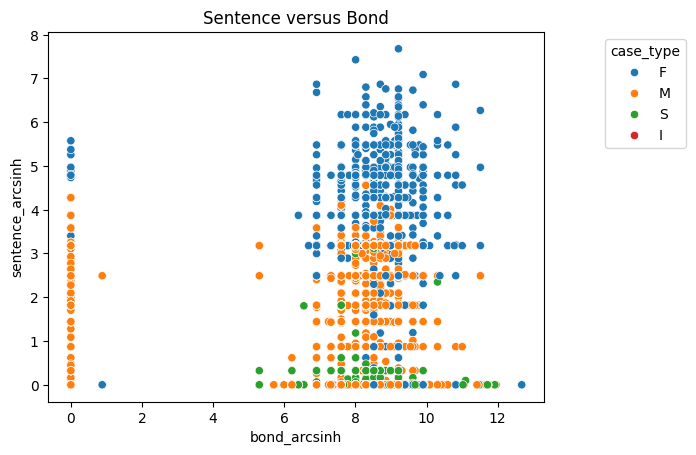

In [243]:
this_plot = sns.scatterplot(data=df, x=var1, y=var2, hue=cat1)
this_plot.set(title='Sentence versus Bond')
sns.move_legend(this_plot, "upper right", bbox_to_anchor=(1.3, 1)) # Moves the Legend

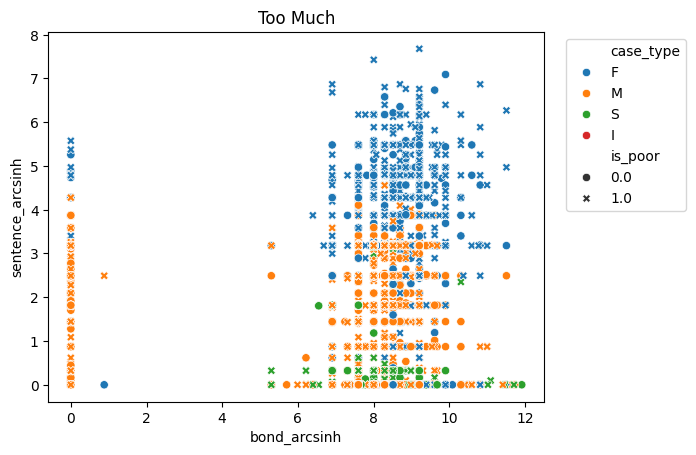

In [244]:
this_plot = sns.scatterplot(data=df, x=var1, y=var2, hue=cat1, style=cat2) # Two kinds of grouping
this_plot.set(title='Too Much')
sns.move_legend(this_plot, "upper right", bbox_to_anchor=(1.3, 1)) # Moves the Legend

- We're making 4D plots here: It's sort of wasted on this example, but you can imagine this ability to color and shape the points could illustrate important multi-dimensional relationships among variables
- We'll come back to this, but scatterplots can be fairly misleading about prevalence:

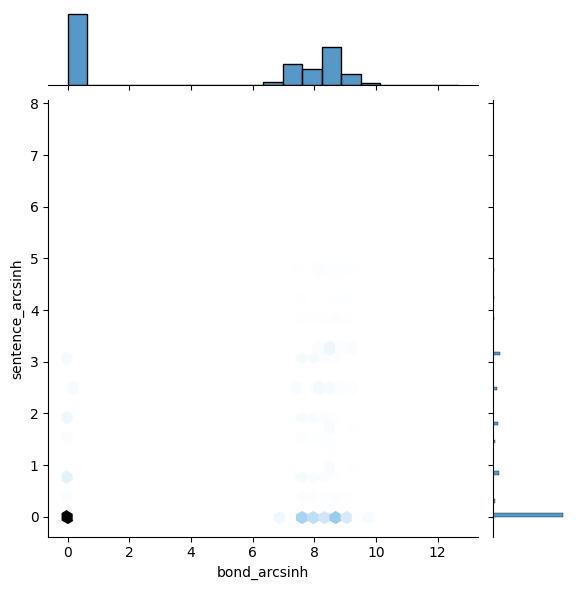

In [245]:
sns.jointplot(data=df, x=var1, y=var2, kind='hex')

## Grouped Descriptions
- We can group our calculations like `.describe()` in a similar way to huing or grouping:
    1. Use `df.loc[:,[group,var]]` to get the subset of the dataframe you want to analyze
    2. Then `.groupby(group).describe()` to apply `.describe()` to `var` for each `group`
- Like the grouped kernel densities, this can be a really useful way of adding context to numbers

In [246]:
var = 'bond'
group = 'case_type'
df.loc[:,[group,var]].groupby(group).describe()

bond                                                         \
             count         mean          std  min     25%     50%     75%   
case_type                                                                   
F           3040.0  3158.421711  4448.766214  0.0  1500.0  2500.0  3525.0   
I              6.0  1250.000000  1508.310313  0.0     0.0   750.0  2250.0   
M          12458.0   972.329363  2089.762114  0.0     0.0     0.0  1500.0   
S           1387.0  2161.847722  3548.012111  0.0  1000.0  1500.0  2500.0   

                      
                 max  
case_type             
F          160000.00  
I            3500.00  
M           78000.00  
S           74962.12

In [247]:
var = 'bond'
group = 'is_poor'
df.loc[:,[group,var]].groupby(group).describe()

bond                                                        \
          count         mean          std  min    25%     50%     75%   
is_poor                                                                 
0.0      9450.0  1035.299351  2255.361676  0.0    0.0     0.0  1500.0   
1.0      6632.0  1999.594260  2828.266454  0.0  500.0  1500.0  2500.0   

                   
              max  
is_poor            
0.0      74962.12  
1.0      61000.00

In [248]:
# You can .groupby multiple variables at once:
df.loc[:,['is_poor','case_type','bond']].groupby(['is_poor','case_type']).describe()

bond                                                 \
                    count         mean          std  min     25%     50%   
is_poor case_type                                                          
0.0     F          1015.0  3270.444335  3727.062229  0.0  1500.0  2500.0   
        I             3.0   833.333333  1443.375673  0.0     0.0     0.0   
        M          7883.0   679.544050  1611.456941  0.0     0.0     0.0   
        S           539.0  2027.332319  3581.322416  0.0  1000.0  1500.0   
1.0     F          1940.0  3028.917526  3301.773144  0.0  1500.0  2500.0   
        I             3.0  1666.666667  1755.942292  0.0   750.0  1500.0   
        M          3948.0  1428.168303  2153.318028  0.0     0.0  1000.0   
        S           733.0  2357.845389  3723.688027  0.0  1000.0  1500.0   

                                     
                      75%       max  
is_poor case_type                    
0.0     F          4000.0  50000.00  
        I          1250.0   2500.00  
        M          1000.0  62195.75  
        S          2500.0  74962.12  
1.0     F          3500.0  50000.00  
        I          2500.0   3500.00  
        M          2000.0  58529.22  
        S          2500.0  61000.00

- So, we can see that for Felony charges, indigency status doesn't seem to influence the outcome, but for Misdemeanor charges it does

## Time Series Data
- Often, we have data collected over time. There's a taxonomy:
    - Cross-Sectional Data: There is a variable $y_i$ recorded for $i = 1, ..., N$ observational units
    - Time Series: There is a variable $y_{t}$ recorded each period $t=0,...,T$
    - Panel Data: Each observational unit $i = 1,...,N$ is recorded in each period $t=0$ up to $t=T$, yielding a panel of data $y_{it}$. If there is an observation $y_{it}$ for each $i$ in each period $t$, the panel is balanced; otherwise it is unbalanced.

- We mostly focus on cross-sectional data in this class: You could easily take two or three courses on time series analysis alone. 
- Time Series is like stock prices: Each series just ticks another value each period.
- Panel Data is like clinical trials: There are patients $i$ over time $t$, and patients enter or exit the study, and there might be multiple cohorts or different treatments. A patient $i$ might miss an appointment at time $t$, so the data quality vary across patients.
- Since the points are connected over time, we... connect them over time
- On the analytics side, you can spend as much time as you want studying time series: Whole books, whole courses, whole careers

## Example: U.S. Power Consumption Over Time
- Let's plot United Stats power consumption stats: Where does it come from? How is it generated? How much is used?

In [249]:
tdf = pd.read_csv('./data/us_power_consumption.csv')
tdf.head()

,Annual Total,Total Fossil Fuels Production (quadBTU),Nuclear Electric Power Production (quadBTU),Total Renewable Energy Production (quadBTU),Total Primary Energy Production (quadBTU),Primary Energy Imports (quadBTU),Primary Energy Exports (quadBTU),Primary Energy Net Imports (quadBTU),Primary Energy Stock Change and Other (quadBTU),Total Fossil Fuels Consumption (quadBTU),Nuclear Electric Power Consumption (quadBTU),Total Renewable Energy Consumption (quadBTU),Total Primary Energy Consumption (quadBTU)
0,1949,28.740479,0.0,1.872627,30.613106,1.448158,1.591760,-0.143602,0.396915,28.988371,0.0,1.872627,30.866419
1,1950,32.553205,0.0,1.906525,34.459730,1.912887,1.465322,0.447565,-1.379921,31.614755,0.0,1.906525,33.527374
2,1951,35.782118,0.0,1.890800,37.672919,1.892425,2.621545,-0.729119,-1.057801,33.987736,0.0,1.890800,35.885997
3,1952,34.964662,0.0,1.848694,36.813356,2.145984,2.365131,-0.219147,-0.959659,33.778116,0.0,1.848694,35.634550
4,1953,35.338361,0.0,1.792616,37.130976,2.313042,1.866013,0.447029,-0.976252,34.802286,0.0,1.792616,36.601753


[Text(0.5, 1.0, 'Total U.S. Energy Consumption'),
 Text(0.5, 0, 'Year'),
 Text(0, 0.5, 'Quadrillions BTU')]

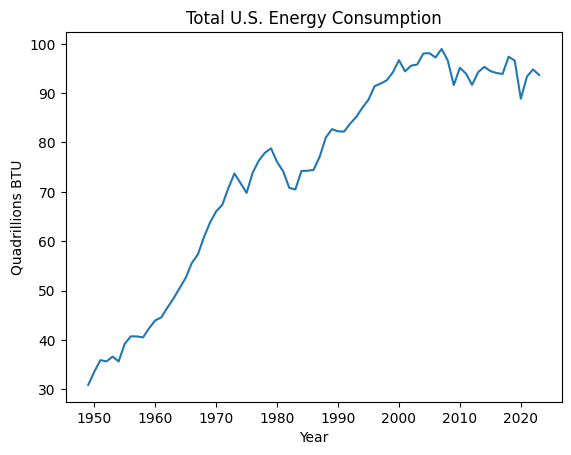

In [250]:
fig = sns.lineplot(data = tdf, x = 'Annual Total', 
                   y = 'Total Primary Energy Consumption (quadBTU)')
fig.set(title="Total U.S. Energy Consumption", 
        xlabel='Year', ylabel='Quadrillions BTU')

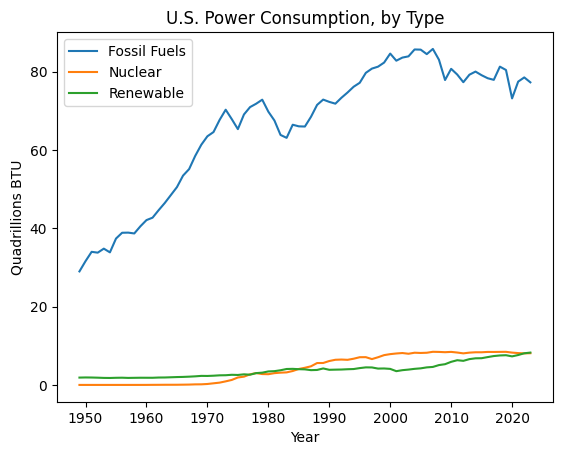

In [251]:
fig = sns.lineplot(data = tdf, x = 'Annual Total', 
             y = 'Total Fossil Fuels Consumption (quadBTU)', label = 'Fossil Fuels')
sns.lineplot(data = tdf, x = 'Annual Total', 
             y = 'Nuclear Electric Power Consumption (quadBTU)', label = 'Nuclear')
sns.lineplot(data = tdf, x = 'Annual Total', 
             y = 'Total Renewable Energy Consumption (quadBTU)', label = 'Renewable')
fig.set(title="U.S. Power Consumption, by Type", 
        xlabel='Year', ylabel='Quadrillions BTU')
plt.show()

- Huh. Well, moving right along...

## Example: Time Use Data
- How do Americans spend their time over their lives?
- A row gives the fraction of time spent on each activity at that age, a column is an activity
- This format of data comes up a lot, and it is often inconvenient to work with

In [252]:
tdf = pd.read_csv('./data/time_use.csv')
print(tdf.shape)
print(tdf.columns)

tdf = tdf.rename(columns = {'Year':'year',
                            'Time spent alone, by age of respondent (United States)':'alone',
       'Time spent with friends, by age of respondent (United States)':'friends',
       'Time spent with children, by age of respondent (United States)':'children',
       'Time spent with with parents, siblings and other family, by age of respondent (United States)':'family',
       'Time spent with partner, by age of respondent (United States)':'partner',
       'Time spent with coworkers, by age of respondent (United States)':'coworkers'})

# Converts time levels to proportions:
props = tdf.iloc[:,1:7]
tdf.iloc[:,1:7] = props.apply(lambda x: x/x.sum(), axis=1) # Convert minutes to proportions
tdf.head()

(67, 7)
Index(['Year', 'Time spent alone, by age of respondent (United States)',
       'Time spent with friends, by age of respondent (United States)',
       'Time spent with children, by age of respondent (United States)',
       'Time spent with with parents, siblings and other family, by age of respondent (United States)',
       'Time spent with partner, by age of respondent (United States)',
       'Time spent with coworkers, by age of respondent (United States)'],
      dtype='object')


,year,alone,friends,children,family,partner,coworkers
0,15,0.321294,0.181858,0.038999,0.443983,0.000000,0.013865
1,16,0.330923,0.177579,0.045877,0.407841,0.000049,0.037730
2,17,0.347324,0.186572,0.040422,0.356066,0.001740,0.067877
3,18,0.331773,0.188308,0.037439,0.323097,0.007788,0.111595
4,19,0.343517,0.166577,0.046750,0.258191,0.024810,0.160154


- I have 6 time series, where the time index is years from 15 to 85.

## Melting Data
- The most common data wrangling problem with time series data is that the data are stored in a matrix where the rows/columns correspond to observations and time, or vice versa
- The `df.melt(id_vars=index)` method turns the columns into rows that correspond to the `index` variable
- This is super useful for all kinds of data, often with a time dimension but not always
- This is essential for making a lot of useful visualizations
- Once the data are in this form, you can use the `index` as the variable on the horizontal axis, the `value` variable on the vertical axis, and hue by `variable` to get a time series plot

In [253]:
hdf = tdf.melt(id_vars='year') # Melt the data
hdf.head()

,year,variable,value
0,15,alone,0.321294
1,16,alone,0.330923
2,17,alone,0.347324
3,18,alone,0.331773
4,19,alone,0.343517


[Text(0.5, 1.0, 'Time Use'), Text(0.5, 0, 'Year'), Text(0, 0.5, 'Proportion')]

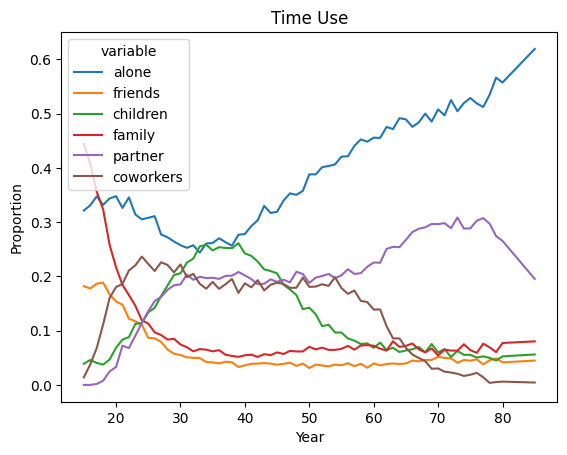

In [254]:
# This is the most depressing graph I've ever made:
fig = sns.lineplot(data=hdf,x='year',y='value',hue='variable')
fig.set(title='Time Use',xlabel='Year',ylabel='Proportion')

## Recurrence
- The most basic question to ask about a time series is, "Is there anything to learn from this?"
- A series is **stationary/ergodic** if its statistical properties do not depend on the time period in which it is observed. It is **non-stationary** or **integrated** if the "calendar date" significantly explains its values and behavior. 
- You can't really learn about a truly non-ergodic process, since it doesn't repeat itself, so there are no patterns to learn about. 
- If you have an integrated time series and want to analyze, you can try to difference it, $z_t = y_t - y_{t-1}$, until it becomes stationary
- Let's look at some tech stocks

In [255]:
tech = ['AAPL', 'MSFT', 'NFLX', 'AMZN', 'META', 'GOOG', 'NVDA', 'FB', ]
tdf = pd.read_csv('./data/tech_stocks.csv', low_memory=False)
tdf.loc[:,'date'] = pd.to_datetime(tdf['date'], format='%Y-%m-%d') # Make date a time variable

print(tdf['symbol'].value_counts())

tdf.head()

symbol
MSFT    5899
AAPL    5899
AMZN    5899
NVDA    5633
NFLX    4796
FB      2282
GOOG    1816
Name: count, dtype: int64


,Unnamed: 0,symbol,date,open,high,low,close,close_adjusted,volume,split_coefficient
0,0,MSFT,2016-05-16 00:00:00,50.80,51.96,50.75,51.83,49.7013,20032017,1.0
1,1,MSFT,2002-01-16 00:00:00,68.85,69.84,67.85,67.87,22.5902,30977700,1.0
2,2,MSFT,2001-09-18 00:00:00,53.41,55.00,53.17,54.32,18.0802,41591300,1.0
3,3,MSFT,2007-10-26 00:00:00,36.01,36.03,34.56,35.03,27.2232,288121200,1.0
4,4,MSFT,2014-06-27 00:00:00,41.61,42.29,41.51,42.25,38.6773,74640000,1.0


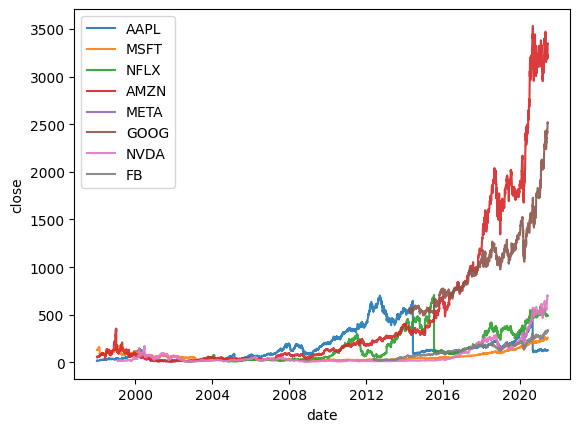

In [256]:
for symbol in tech:
    rdf = tdf[ tdf['symbol'] == symbol ]
    sns.lineplot(x='date',y='close',data=rdf, label = symbol, alpha=.9)

[Text(0.5, 1.0, 'AMZN')]

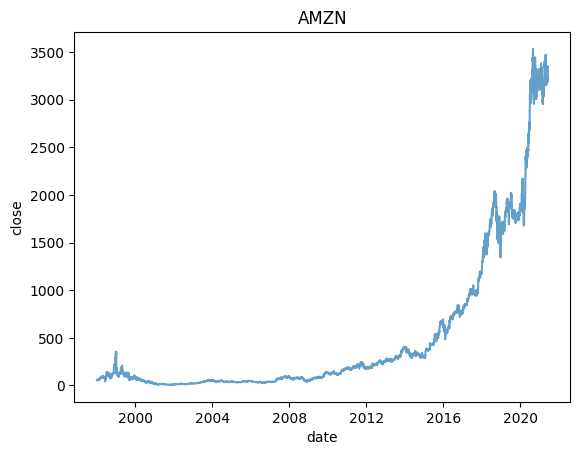

In [257]:
amzn = tdf[ tdf['symbol']=='AMZN' ]
fig = sns.lineplot(x='date',y='close',data=amzn, alpha=.7) # This is not stationary
fig.set(title='AMZN')

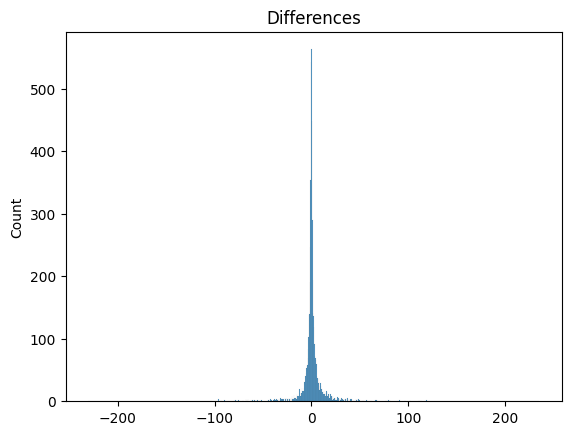

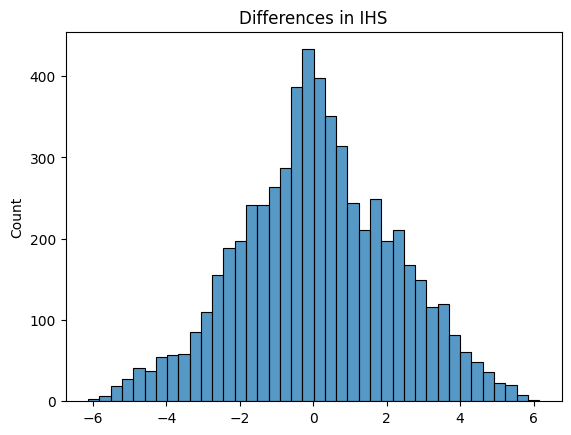

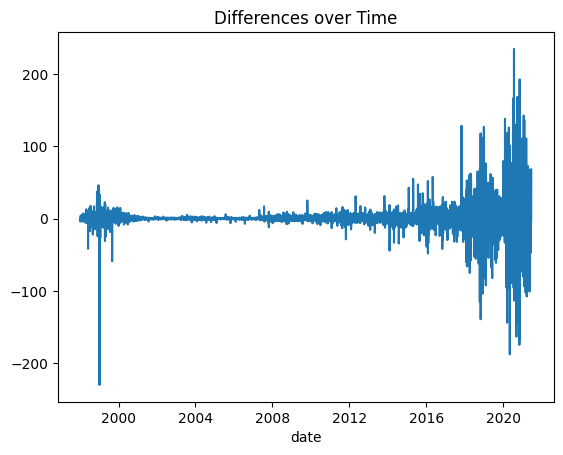

In [258]:
amzn = tdf[ tdf['symbol']=='AMZN' ]
amzn = amzn.sort_values('date')
y = amzn['close'].to_numpy()
t = len(y)

diff = y[1:]-y[:(t-1)] # First difference of Amazon prices

fig = sns.histplot(diff)
fig.set(title='Differences')
plt.show()

fig = sns.histplot(np.arcsinh(diff))
fig.set(title='Differences in IHS')
plt.show()

fig = sns.lineplot(x=amzn['date'][1:],y=diff) # This is stationary
fig.set(title='Differences over Time')
plt.show()


- Look at that volatility! Yee-haw!
- The stock price is essentially the integrated sum of draws from the "changes" distribution
- Seriously, there was a tech crash in 2000 called the "dotcom bubble". The volatility around 2000 is nothing compared to post 2016.
- Maybe we should be deflating the prices due to inflation?